In [85]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, add_changepoints_to_plot

In [50]:
df = pd.read_csv('data/mergedData.csv')
df.set_index('Timestamp', inplace=True)
df.index = pd.to_datetime(df.index)
data = pd.DataFrame(df.Southm3DO).dropna()
data = data.rename(columns = {'Southm3DO' : 'y'})
data['ds'] = data.index

In [3]:
def optimize_prophet_changepoint(data,intial_param,epoch):
  MSEs={}
  changepoint=intial_param

  #The function iteratively changes the changepoint scale based on user-defined epoch range, measuring the error for each value. 

  for i in range(epoch):
    proph = Prophet(changepoint_prior_scale=changepoint)
    proph.fit(data)
    forecast = proph.make_future_dataframe(periods=0, freq='D')
    forecast = proph.predict(forecast)
    y_true=data['y']
    y_pred=forecast['yhat']
    error=mean_squared_error(y_true, y_pred)
    MSEs[changepoint]=error
    changepoint+=0.0001
  
  #The function automatically selects a changepoint scale parameter based on the lowest error rate.

  optim=min(list(MSEs.values()))
  for key,value in MSEs.items():
    if optim==value:
      k=key
      print('Optimal Changepoint is',key,'for an MSE of',value)
  return k

In [9]:
changepoint=optimize_prophet_changepoint(data,0.00005,10)
print('Changepoint optimized:',changepoint)
#Optimal Changepoint is 0.009949999999999995 for an MSE of 15.416283168832447

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=Tru

Optimal Changepoint is 0.009949999999999995 for an MSE of 15.416283168832447
Changepoint optimized: 0.009949999999999995


In [68]:
prophet = Prophet(
    changepoint_prior_scale=changepoint,
    interval_width=0.95)


In [69]:
X_train, X_test, data_train, data_test = train_test_split(data.index.values, data, test_size=0.25, shuffle= False)
prophet.fit(data_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [88]:
forecast = prophet.make_future_dataframe(periods=data_test.shape[0], freq='T')
forecast = prophet.predict(forecast)
y_true=data_test['y']
y_pred=forecast['yhat'][:len(y_true)]
print(mean_squared_error(y_true,y_pred, squared = False))

16.673714202121374


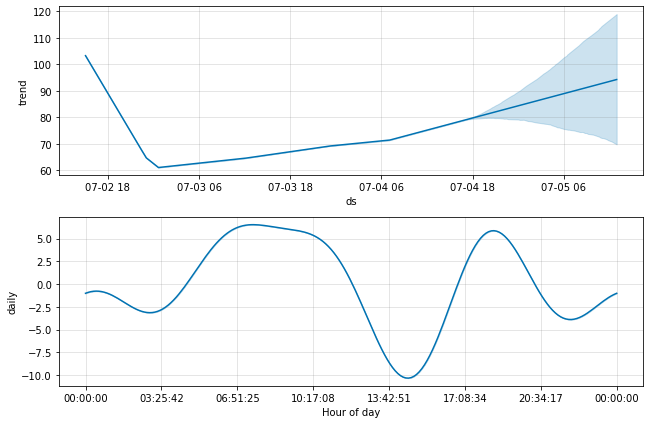

In [72]:
prophet.plot_components(forecast);

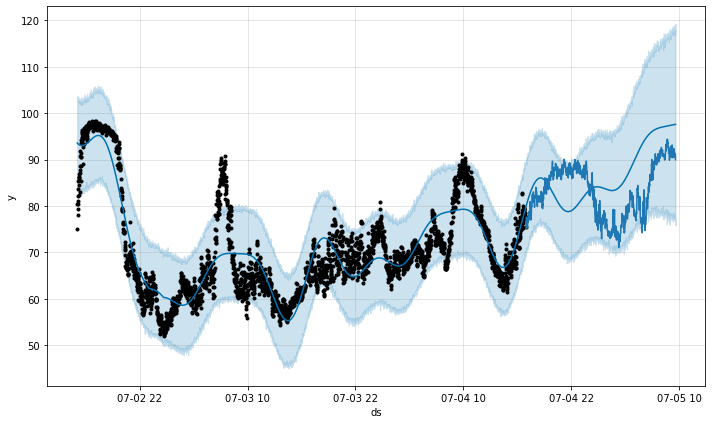

In [89]:
fig =prophet.plot(forecast);
plt.plot(data_test.y)
#a = add_changepoints_to_plot(fig.gca(), prophet, forecast)

In [31]:
cv = cross_validation(prophet, initial ='1800 minutes', period = '180 minutes', horizon = '260 minutes', parallel ='processes')

INFO:prophet:Making 11 forecasts with cutoffs between 2019-07-03 23:16:00 and 2019-07-05 05:16:00


  0%|          | 0/11 [00:00<?, ?it/s]

In [34]:
cv_p = performance_metrics(cv)
cv_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 00:26:00,33.771339,5.811311,4.805210,0.052819,0.043742,0.052843,0.664336
1,0 days 00:27:00,35.683587,5.973574,4.925422,0.054244,0.043888,0.054177,0.657343
2,0 days 00:28:00,37.493428,6.123188,5.040334,0.055633,0.043926,0.055464,0.650350
3,0 days 00:29:00,39.588203,6.291916,5.166314,0.057158,0.044069,0.056882,0.639860
4,0 days 00:30:00,41.742418,6.460837,5.287435,0.058666,0.045432,0.058270,0.632867


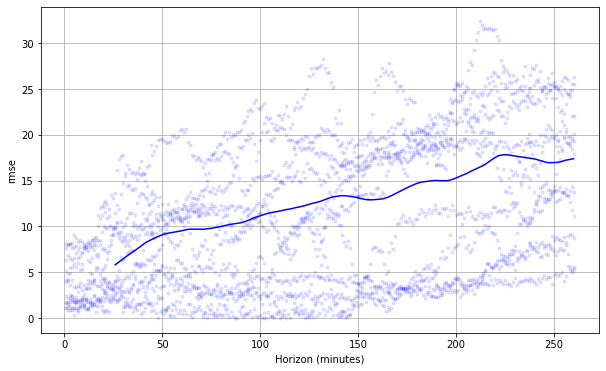

In [42]:
plot_cross_validation_metric(cv, metric = 'rmse');